# Neural Topic Modeling with VAE
Complete implementation of a Variational Autoencoder (VAE) for topic modeling with numerical stability fixes.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import matplotlib.pyplot as plt

## Load and Preprocess Dataset

In [2]:
# Load dataset
print("Loading 20 newsgroups dataset...")
data = fetch_20newsgroups(
    subset='all',
    remove=('headers', 'footers', 'quotes')
)

documents = data.data[:3000]  # keep small for speed
print(f"Loaded {len(documents)} documents")

# Convert text → Bag of Words
vectorizer = CountVectorizer(
    stop_words='english',
    max_features=2000,
    min_df=5,
    max_df=0.7
)

X = vectorizer.fit_transform(documents)
X = X.toarray()

# Normalize: convert to document-term probabilities
X_normalized = X / (X.sum(axis=1, keepdims=True) + 1e-10)

X = torch.tensor(X_normalized, dtype=torch.float32)
print(f"Data shape: {X.shape}")
print(f"Vocab size: {len(vectorizer.get_feature_names_out())}")

# Get vocabulary
vocab = vectorizer.get_feature_names_out().tolist()

Loading 20 newsgroups dataset...
Loaded 3000 documents
Data shape: torch.Size([3000, 2000])
Vocab size: 2000


## Fixed VAE Model Architecture

In [3]:
class NeuralTopicModel(nn.Module):
    """Variational Autoencoder for topic modeling"""
    
    def __init__(self, vocab_size, hidden_size=256, num_topics=20):
        super().__init__()
        
        # Encoder: document → hidden → latent space
        self.fc1 = nn.Linear(vocab_size, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, num_topics)
        self.fc_logvar = nn.Linear(hidden_size, num_topics)
        
        # Decoder: latent space → document
        self.fc_decoder = nn.Linear(num_topics, vocab_size)
        
        # Initialize with Xavier uniform for stability
        for layer in [self.fc1, self.fc_mu, self.fc_logvar, self.fc_decoder]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
    
    def encode(self, x):
        """Encode document to latent distribution"""
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick for sampling"""
        # Clamp logvar for numerical stability
        logvar = torch.clamp(logvar, -20, 20)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        """Decode latent vector back to document"""
        # Output log-probabilities for stability
        logits = self.fc_decoder(z)
        # Use log_softmax for numerical stability
        return torch.log_softmax(logits, dim=1)
    
    def forward(self, x):
        """Forward pass"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        log_recon = self.decode(z)
        return log_recon, mu, logvar, z


# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = NeuralTopicModel(vocab_size=len(vocab), hidden_size=256, num_topics=20)
model = model.to(device)
print(f"Model initialized with {len(vocab)} vocabulary size and 20 topics")

Using device: cpu
Model initialized with 2000 vocabulary size and 20 topics


## Stable Loss Function with KL Annealing

In [4]:
def elbo_loss(log_recon, x, mu, logvar, kl_weight=1.0):
    """
    ELBO (Evidence Lower BOund) loss for VAE
    
    Args:
        log_recon: log probabilities from decoder [batch_size, vocab_size]
        x: normalized document counts [batch_size, vocab_size]
        mu: latent mean [batch_size, num_topics]
        logvar: latent log-variance [batch_size, num_topics]
        kl_weight: weight for KL divergence (annealing schedule)
    
    Returns:
        loss: scalar loss value
    """
    # Reconstruction loss: negative log-likelihood
    # Using log probabilities for numerical stability
    recon_loss = -(x * log_recon).sum(dim=1).mean()
    
    # Clamp logvar for stability
    logvar = torch.clamp(logvar, -20, 20)
    
    # KL divergence: KL(q(z|x) || p(z))
    # where p(z) = N(0, I) is standard normal prior
    kl_loss = -0.5 * torch.mean(
        torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    )
    
    # Total ELBO loss
    total_loss = recon_loss + kl_weight * kl_loss
    
    return total_loss, recon_loss, kl_loss

print("Loss function defined with numerical stability features")

Loss function defined with numerical stability features


## Train Model with Stability Fixes

In [5]:
# Training configuration
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Much lower learning rate!
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

epochs = 30
batch_size = 64
max_grad_norm = 1.0  # Gradient clipping

# Move data to device
X = X.to(device)

# Training history
history = {'loss': [], 'recon': [], 'kl': []}

print("Starting training...")
for epoch in range(epochs):
    # KL annealing: gradually increase KL weight
    kl_weight = min(1.0, (epoch + 1) / 10.0)
    
    perm = torch.randperm(X.size(0))
    total_loss = 0
    total_recon = 0
    total_kl = 0
    num_batches = 0
    
    for i in tqdm(range(0, X.size(0), batch_size), desc=f"Epoch {epoch+1}/{epochs}"):
        batch = X[perm[i:i+batch_size]]
        
        optimizer.zero_grad()
        
        # Forward pass
        log_recon, mu, logvar, z = model(batch)
        
        # Calculate loss
        loss, recon_loss, kl_loss = elbo_loss(log_recon, batch, mu, logvar, kl_weight=kl_weight)
        
        # Check for NaN/Inf
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Warning: NaN/Inf detected in loss at batch {i}. Skipping batch.")
            continue
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()
        num_batches += 1
    
    # Learning rate scheduling
    scheduler.step()
    
    # Average losses
    avg_loss = total_loss / num_batches
    avg_recon = total_recon / num_batches
    avg_kl = total_kl / num_batches
    
    history['loss'].append(avg_loss)
    history['recon'].append(avg_recon)
    history['kl'].append(avg_kl)
    
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f} | KL_w: {kl_weight:.2f}")

print("Training complete!")

Starting training...


Epoch 1/30: 100%|██████████| 47/47 [00:00<00:00, 174.33it/s]


Epoch 1/30 | Loss: 7.3463 | Recon: 7.3462 | KL: 0.0010 | KL_w: 0.10


Epoch 2/30: 100%|██████████| 47/47 [00:00<00:00, 141.02it/s]


Epoch 2/30 | Loss: 7.3427 | Recon: 7.3425 | KL: 0.0011 | KL_w: 0.20


Epoch 3/30: 100%|██████████| 47/47 [00:00<00:00, 186.08it/s]


Epoch 3/30 | Loss: 7.3429 | Recon: 7.3426 | KL: 0.0009 | KL_w: 0.30


Epoch 4/30: 100%|██████████| 47/47 [00:00<00:00, 180.93it/s]


Epoch 4/30 | Loss: 7.3380 | Recon: 7.3377 | KL: 0.0007 | KL_w: 0.40


Epoch 5/30: 100%|██████████| 47/47 [00:00<00:00, 193.59it/s]


Epoch 5/30 | Loss: 7.3373 | Recon: 7.3370 | KL: 0.0006 | KL_w: 0.50


Epoch 6/30: 100%|██████████| 47/47 [00:00<00:00, 198.27it/s]


Epoch 6/30 | Loss: 7.3363 | Recon: 7.3360 | KL: 0.0006 | KL_w: 0.60


Epoch 7/30: 100%|██████████| 47/47 [00:00<00:00, 157.92it/s]


Epoch 7/30 | Loss: 7.3320 | Recon: 7.3317 | KL: 0.0005 | KL_w: 0.70


Epoch 8/30: 100%|██████████| 47/47 [00:00<00:00, 190.96it/s]


Epoch 8/30 | Loss: 7.3308 | Recon: 7.3304 | KL: 0.0005 | KL_w: 0.80


Epoch 9/30: 100%|██████████| 47/47 [00:00<00:00, 200.81it/s]


Epoch 9/30 | Loss: 7.3281 | Recon: 7.3276 | KL: 0.0005 | KL_w: 0.90


Epoch 10/30: 100%|██████████| 47/47 [00:00<00:00, 188.32it/s]


Epoch 10/30 | Loss: 7.3270 | Recon: 7.3266 | KL: 0.0004 | KL_w: 1.00


Epoch 11/30: 100%|██████████| 47/47 [00:00<00:00, 163.43it/s]


Epoch 11/30 | Loss: 7.3236 | Recon: 7.3231 | KL: 0.0004 | KL_w: 1.00


Epoch 12/30: 100%|██████████| 47/47 [00:00<00:00, 190.68it/s]


Epoch 12/30 | Loss: 7.3235 | Recon: 7.3231 | KL: 0.0004 | KL_w: 1.00


Epoch 13/30: 100%|██████████| 47/47 [00:00<00:00, 187.69it/s]


Epoch 13/30 | Loss: 7.3238 | Recon: 7.3234 | KL: 0.0004 | KL_w: 1.00


Epoch 14/30: 100%|██████████| 47/47 [00:00<00:00, 157.40it/s]


Epoch 14/30 | Loss: 7.3211 | Recon: 7.3207 | KL: 0.0004 | KL_w: 1.00


Epoch 15/30: 100%|██████████| 47/47 [00:00<00:00, 187.92it/s]


Epoch 15/30 | Loss: 7.3218 | Recon: 7.3214 | KL: 0.0004 | KL_w: 1.00


Epoch 16/30: 100%|██████████| 47/47 [00:00<00:00, 165.41it/s]


Epoch 16/30 | Loss: 7.3192 | Recon: 7.3187 | KL: 0.0004 | KL_w: 1.00


Epoch 17/30: 100%|██████████| 47/47 [00:00<00:00, 132.36it/s]


Epoch 17/30 | Loss: 7.3179 | Recon: 7.3175 | KL: 0.0004 | KL_w: 1.00


Epoch 18/30: 100%|██████████| 47/47 [00:00<00:00, 139.69it/s]


Epoch 18/30 | Loss: 7.3175 | Recon: 7.3171 | KL: 0.0004 | KL_w: 1.00


Epoch 19/30: 100%|██████████| 47/47 [00:00<00:00, 165.16it/s]


Epoch 19/30 | Loss: 7.3149 | Recon: 7.3145 | KL: 0.0004 | KL_w: 1.00


Epoch 20/30: 100%|██████████| 47/47 [00:00<00:00, 160.37it/s]


Epoch 20/30 | Loss: 7.3152 | Recon: 7.3147 | KL: 0.0004 | KL_w: 1.00


Epoch 21/30: 100%|██████████| 47/47 [00:00<00:00, 140.27it/s]


Epoch 21/30 | Loss: 7.3144 | Recon: 7.3139 | KL: 0.0004 | KL_w: 1.00


Epoch 22/30: 100%|██████████| 47/47 [00:00<00:00, 162.51it/s]


Epoch 22/30 | Loss: 7.3119 | Recon: 7.3115 | KL: 0.0004 | KL_w: 1.00


Epoch 23/30: 100%|██████████| 47/47 [00:00<00:00, 141.95it/s]


Epoch 23/30 | Loss: 7.3133 | Recon: 7.3128 | KL: 0.0004 | KL_w: 1.00


Epoch 24/30: 100%|██████████| 47/47 [00:00<00:00, 149.89it/s]


Epoch 24/30 | Loss: 7.3123 | Recon: 7.3119 | KL: 0.0005 | KL_w: 1.00


Epoch 25/30: 100%|██████████| 47/47 [00:00<00:00, 131.77it/s]


Epoch 25/30 | Loss: 7.3124 | Recon: 7.3120 | KL: 0.0005 | KL_w: 1.00


Epoch 26/30: 100%|██████████| 47/47 [00:00<00:00, 134.37it/s]


Epoch 26/30 | Loss: 7.3130 | Recon: 7.3125 | KL: 0.0005 | KL_w: 1.00


Epoch 27/30: 100%|██████████| 47/47 [00:00<00:00, 141.90it/s]


Epoch 27/30 | Loss: 7.3114 | Recon: 7.3110 | KL: 0.0005 | KL_w: 1.00


Epoch 28/30: 100%|██████████| 47/47 [00:00<00:00, 127.46it/s]


Epoch 28/30 | Loss: 7.3112 | Recon: 7.3107 | KL: 0.0005 | KL_w: 1.00


Epoch 29/30: 100%|██████████| 47/47 [00:00<00:00, 133.48it/s]


Epoch 29/30 | Loss: 7.3097 | Recon: 7.3093 | KL: 0.0005 | KL_w: 1.00


Epoch 30/30: 100%|██████████| 47/47 [00:00<00:00, 132.42it/s]

Epoch 30/30 | Loss: 7.3099 | Recon: 7.3094 | KL: 0.0005 | KL_w: 1.00
Training complete!


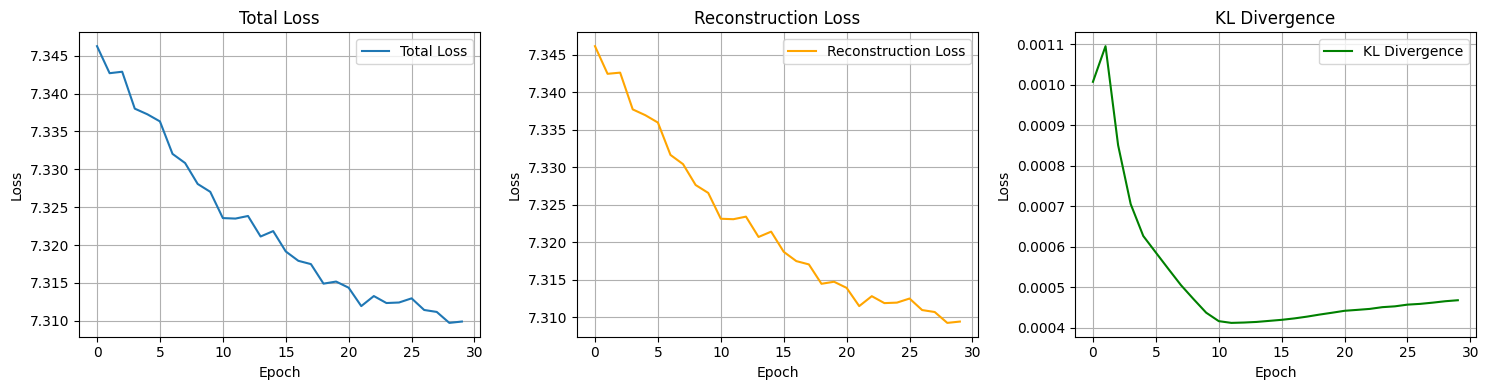

Training curves plotted successfully!


In [6]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['loss'], label='Total Loss')
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['recon'], label='Reconstruction Loss', color='orange')
axes[1].set_title('Reconstruction Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(history['kl'], label='KL Divergence', color='green')
axes[2].set_title('KL Divergence')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("Training curves plotted successfully!")

## Extract and Visualize Topics

In [7]:
def get_top_words(model, vocab, num_topics, top_k=10):
    """Extract top words for each topic"""
    model.eval()
    
    # Create one-hot vectors for each topic
    topic_vectors = torch.eye(num_topics).to(device)
    
    # Decode topics
    with torch.no_grad():
        log_probs = model.decode(topic_vectors)
        probs = torch.exp(log_probs)
    
    topics = {}
    for topic_id in range(num_topics):
        # Get top words for this topic
        top_indices = torch.argsort(probs[topic_id], descending=True)[:top_k]
        top_words = [vocab[idx] for idx in top_indices.cpu().numpy()]
        top_scores = probs[topic_id][top_indices].cpu().numpy()
        
        topics[f'Topic {topic_id}'] = list(zip(top_words, top_scores))
    
    return topics

# Extract topics
num_topics = 20
topics = get_top_words(model, vocab, num_topics, top_k=15)

# Display topics
for topic_name, words in topics.items():
    print(f"\n{topic_name}:")
    for word, score in words:
        print(f"  {word:15s} {score:.4f}")


Topic 0:
  know            0.0006
  good            0.0006
  question        0.0006
  try             0.0006
  did             0.0006
  like            0.0006
  sure            0.0006
  new             0.0006
  didn            0.0006
  way             0.0006
  believe         0.0006
  maybe           0.0006
  10              0.0006
  trying          0.0006
  long            0.0006

Topic 1:
  don             0.0006
  does            0.0006
  ve              0.0006
  like            0.0006
  people          0.0006
  want            0.0006
  years           0.0006
  maybe           0.0006
  post            0.0006
  need            0.0006
  lot             0.0006
  got             0.0006
  kind            0.0006
  idea            0.0006
  way             0.0006

Topic 2:
  just            0.0006
  like            0.0006
  used            0.0006
  probably        0.0006
  know            0.0006
  did             0.0006
  question        0.0006
  run             0.0006
  ll              0.

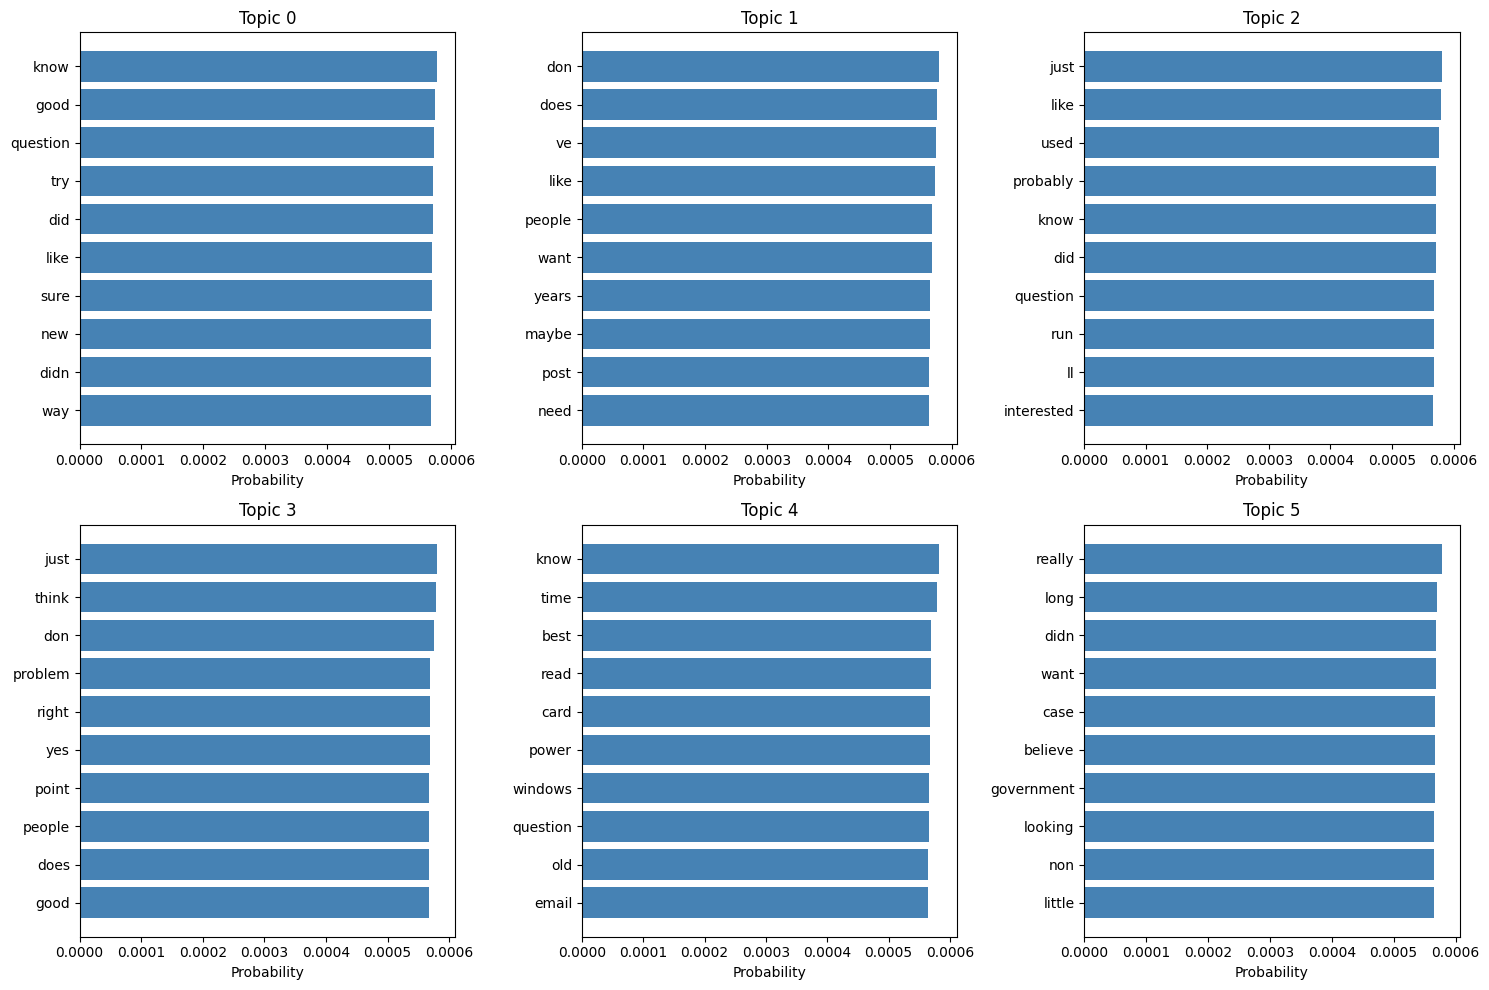

Topic visualizations complete!


In [8]:
# Visualize top 5 topics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

model.eval()
for topic_id in range(6):
    topic_vector = torch.zeros(num_topics).to(device)
    topic_vector[topic_id] = 1.0
    
    with torch.no_grad():
        log_probs = model.decode(topic_vector.unsqueeze(0))
        probs = torch.exp(log_probs)[0]
    
    top_indices = torch.argsort(probs, descending=True)[:10]
    top_words = [vocab[idx] for idx in top_indices.cpu().numpy()]
    top_scores = probs[top_indices].cpu().numpy()
    
    # Plot
    ax = axes[topic_id]
    ax.barh(top_words, top_scores, color='steelblue')
    ax.set_title(f'Topic {topic_id}')
    ax.set_xlabel('Probability')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("Topic visualizations complete!")

## Predict Topics for New Documents

In [9]:
def infer_topics(text, vectorizer, model, device):
    """Infer topic distribution for a new document"""
    # Vectorize text
    doc_vec = vectorizer.transform([text]).toarray()
    doc_vec = doc_vec / (doc_vec.sum() + 1e-10)  # Normalize
    doc_vec = torch.tensor(doc_vec, dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        mu, logvar = model.encode(doc_vec)
        z = model.reparameterize(mu, logvar)
        
        # Get topic probabilities (normalize latent vector)
        topic_probs = torch.softmax(z, dim=1)[0]
    
    return topic_probs.cpu().numpy()

# Test on sample documents
test_docs = [
    "The new computer has amazing graphics and fast processor",
    "Baseball and soccer are popular sports around the world",
    "The car engine is making strange noises"
]

print("Topic predictions for sample documents:\n")
for doc in test_docs:
    print(f"Document: {doc}")
    topic_probs = infer_topics(doc, vectorizer, model, device)
    
    # Show top 3 topics
    top_topics = np.argsort(topic_probs)[-3:][::-1]
    print("Top topics:")
    for topic_id in top_topics:
        print(f"  Topic {topic_id}: {topic_probs[topic_id]:.4f}")
    print()

Topic predictions for sample documents:

Document: The new computer has amazing graphics and fast processor
Top topics:
  Topic 17: 0.1454
  Topic 8: 0.1193
  Topic 1: 0.1128

Document: Baseball and soccer are popular sports around the world
Top topics:
  Topic 9: 0.2032
  Topic 6: 0.1644
  Topic 12: 0.1204

Document: The car engine is making strange noises
Top topics:
  Topic 12: 0.1390
  Topic 3: 0.1298
  Topic 0: 0.1185

